In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

In [2]:
# choose whether to work on a remote machine
location = "remote"
# location = "local"

if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

# Data storage setup

In [67]:
# # import necessary packages

from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs

from rasterio.plot import show
import rioxarray as rio
import rasterio

from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories, utils
from coralshift.dataloading import data_structure, climate_data, bathymetry, reef_extent
from coralshift.utils import directories
from coralshift.plotting import spatial_plots



## Specify your area of interest

The availability of high-resolution (30m) bathymetric data means that areas of interest are currently confided to 4 areas on the Great Barrier Reef (GBR). The following code downloads the specified area of bathymetry data:

| Reef Area Name                	| Latitudes 	| Longitudes 	|
|-------------------------------	|-----------	|------------	|
| Great Barrier Reef A 2020 30m 	| 10-17°S   	| 142-147°E  	|
| Great Barrier Reef B 2020 30m 	| 16-23°S   	| 144-149°E  	|
| Great Barrier Reef C 2020 30m 	| 18-24°S   	| 148-154°E  	|
| Great Barrier Reef D 2020 30m 	| 23-29°S   	| 150-156°E  	|


![bathymetry_regions.png](https://github.com/orlando-code/coralshift/blob/dev-setup/bathymetry_regions.png?raw=true)


Due to the computational load required to run ML models on such high resolution data, bathymetric data is currently upsampled to 4km grid cells and areas are limited to a quarter of the GBR's total area.


In [4]:
# choose resolution (should be above 1000m for processing in decent time)
# native resolutions are 1 (1, "m") or 1/12 degrees (1/12, "d"), or 4000m (4000, "m") or 1000m (1000, "m")
target_resolution_m, target_resolution_d = spatial_data.choose_resolution(
    resolution=4000, unit="m")

print(f"Data will be resampled to {target_resolution_d:.05f} degrees (~{target_resolution_m}m).")

Data will be resampled to 0.03691 degrees (~4000m).


## Bathymetry

In [5]:
# select your area. Region "A" is used in the report
area_name = "C"

reef_areas = bathymetry.ReefAreas()
file_name = reef_areas.get_short_filename(area_name)


bath_dir = directories.get_bathymetry_datasets_dir()
_, xa_bath = bathymetry.generate_bathymetry_xa_da(area_name)
_, xa_bath_upsampled = spatial_data.upsample_and_save_xa_a(
    bath_dir, xa_d=xa_bath, name=file_name, target_resolution_d=target_resolution_d)

Great_Barrier_Reef_C_2020_30m_MSL_cog already exists in /lustre_scratch/orlando-code/datasets/bathymetry
bathymetry_C_0-00030d already exists in /lustre_scratch/orlando-code/datasets/bathymetry


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


Great_Barrier_Reef_C_0-036912d already exists in /lustre_scratch/orlando-code/datasets/bathymetry


In [ ]:
# # compute dasked arrays for plotting
# xa_bath_upsampled = xa_bath_upsampled.compute()

# # N.B. native resolution not plotted since so high (takes ~10 minutes)
# spatial_plots.plot_spatial(xa_bath_upsampled, val_lims=(-50,0), name="depth", 
#     title=f"Bathymetry at {target_resolution_m}m resolution")

## Calculate slopes

In [ ]:
# calculate absolute gradients from bathymetry and save to file
grads, grads_path = bathymetry.generate_gradient_magnitude_nc(extract_variable(xa_bath_upsampled), sigma=1)

In [ ]:
### Display different resolutions
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16,9), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = spatial_plots.plot_spatial(xa_bath_upsampled, 
    fax= (fig,ax_left), val_lims=(-50,0), name="depth", title=f"Bathymetry at {target_resolution_m}m resolution")
ax2 = spatial_plots.plot_spatial(grads, 
    fax=(fig, ax_right), val_lims=(0,10), name="gradient magnitude", 
    title=f"Absolute seafloor gradients at {target_resolution_m}m resolution")

## Coral ground truth: Allen Coral Atlas


There is currently no API for accessing data directly from your local machine. Please follow the instructions* below:
1. Make an account on the [Allen Coral Atlas](https://allencoralatlas.org/atlas/#6.00/-13.5257/144.5000) webpage
2. Generate a geojson file using the code cell below (generated in the `reef_baseline` directory)

*Instructions correct as of 30.06.23

In [ ]:
# generate geojson file in reef_baseline directory for download from the Allen Coral Atlas
geojson_path = reef_extent.generate_area_geojson(
    area_class = reef_areas, area_name=file_name, save_dir=directories.get_reef_baseline_dir())

print(f"geoJSON file saved at {geojson_path} for upload to GEE")

3. Upload the geojson file via:

    \> My Areas > Upload a GeoJSON or KML file
4. Specify a region name and navigate to the "Download data" tab when it becomes available.
4. Select "Benthic Map (OGC GeoPackage (.gpkg))". Sign the terms and conditions 
and select "Prepare Download". After ~two minutes a sequence of emails will arrive notifying you that your download is ready.
5. Download the file and unzip it using a unzipping utility. Then, add the `benthic.gpkg` file to the `reef_baseline` directory.
6. Continue with the subsequent code cells.

----

You have now downloaded:

**`benthic.gpkg`**

This is a dataframe of Shapely objects ("geometry" polygons) defining the boundaries of different benthic classes:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|

In [ ]:
# read .gpkg file and save to .pkl format for faster reading later
benthic_df = file_ops.check_pkl_else_read_gpkg(directories.get_reef_baseline_dir(), filename = "benthic.pkl")
benthic_df.head()

### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. Doing this locally through rasterio requires such significant compute that cloud computing is the only reasonable option. A JavaScript file (`rasterization.js`) for use in Google Earth Engine (GEE) is accessible [here](https://code.earthengine.google.com/ae68c68309b04643e8f5f5dc45f0dbca). Visit [this page](https://developers.google.com/earth-engine/guides/getstarted) for information regarding setting up a GEE account and getting started.

GEE requires shapefile (.shp) format to ingest data. This is generated in the following cell:


In [ ]:
# process df to gpd.GeoDataFrame. 
# We are interested only in the "Coral/Algae" class, so gdf is limited to these rows by default
gdf_coral = reef_extent.process_benthic_pd(benthic_df)
# save as shapely file (if not already present) for rasterisation in GEE
reef_extent.generate_coral_shp(gdf_coral)

1. Ingest the shapefile (and all accompanying files: .cpg, .dbf, .prj, .shx) as a GEE asset.
2. Import the subsequent `Table` into the script.
3. Update the `resolution` variable as desired (usually that matching the target resolution specified above).
3. Run the script, and submit the `coral_raster_Xm` task. Sit back and wait! After ~1 hour (depending on the chosen resolution) the rasters will be available to download from your Google Drive as GeoTIFFS: after this, add them to the `reef_baseline` directory and carry on with the following cells.

In [ ]:
# process all tifs in folder, casting to nc files for future use
reef_extent.process_reef_extent_tifs()


In [ ]:
# TODO: automated visualisation

gt_tif_dict['coral_raster_1000m'].plot()

## Global Ocean Physics Reanalysis

The dataset metadata can be accessed [here](https://doi.org/10.48670/moi-00021).

### Download data

You're required to set up an account with the [Copernicus Marine Service](https://marine.copernicus.eu/). 


**Warning:**  this is a large amount of data for which the only way to gather it is to query the copernicus API via motu. Requests are queued, and request sizes are floated to the top of the queue. The following functions take advantage of this by splitting a single request up by date adn variable before amalgamating the files, but this can still take a **very long time**, and vary significantly depending on overall website traffic. For those who aren't interested in the entire database, it's highly recommended that you use the toy dataset provided as a `.npy` file in the GitHub repository.


In [60]:
from __future__ import annotations

import numpy as np
import xarray as xa
import os
import cdsapi

# import getpass

# import cdsapi

from pathlib import Path
from tqdm import tqdm
from pandas._libs.tslibs.timestamps import Timestamp

from coralshift.utils import utils, file_ops, directories
from coralshift.processing import spatial_data

def generate_spatiotemporal_var_filename_from_dict(
    info_dict: dict,
) -> str:
    """Generate a filename based on variable, date, and coordinate limits.

    Parameters
    ----------
    info_dict (dict): A dictionary containing information about the variable, date, and coordinate limits.

    Returns
    -------
    str: The generated filename.
    """
    filename_list = []
    for k, v in info_dict.items():
        # strings (variables)
        if utils.is_type_or_list_of_type(v, str):
            filename_list.extend(
                [
                    k.upper(),
                    utils.replace_dot_with_dash(utils.underscore_str_of_strings(v)),
                ]
            )
        # np.datetime64 (dates)
        elif utils.is_type_or_list_of_type(
            v, np.datetime64
        ) or utils.is_type_or_list_of_type(v, Timestamp):
            filename_list.extend(
                [
                    k.upper(),
                    utils.replace_dot_with_dash(utils.underscore_str_of_dates(v)),
                ]
            )
        # tuples (coordinates limits)
        elif utils.is_type_or_list_of_type(v, tuple):
            filename_list.extend(
                [
                    k.upper(),
                    utils.replace_dot_with_dash(
                        utils.underscore_list_of_tuples(utils.round_list_tuples(v))
                    ),
                ]
            )
    return "_".join(filename_list)


def generate_metadata(
    download_dir: str,
    filename: str,
    variables: list[str],
    date_lims: tuple[str, str],
    lon_lims: list[float],
    lat_lims: list[float],
    depth_lims: list[float],
    query: str = "n/a",
) -> None:
    """Generate metadata for the downloaded file and save it as a JSON file.

    Parameters
    ----------
    download_dir (str): The directory where the file is downloaded.
    filename (str): The name of the file.
    variable (str): The variable acronym.
    date_lims (tuple[str, str]): A tuple containing the start and end dates.
    lon_lims (list[float]): A list containing the longitude limits.
    lat_lims (list[float]): A list containing the latitude limits.
    depth_lims (list[float]): A list containing the depth limits.
    query (str): The MOTU query used for downloading the file.
    """
    filepath = (Path(download_dir) / filename).with_suffix(".json")

    var_dict = {
        "mlotst": "ocean mixed layer thickness (sigma theta)",
        "siconc": "sea ice area fraction",
        "thetao": "sea water potential temperature",
        "usi": "eastward sea ice velocity",
        "sithick": "sea ice thickness",
        "bottomT": "sea water potential temperature at sea floor",
        "vsi": "northward sea ice velocity",
        "usi": "eastward sea ice velocity",
        "vo": "northward sea water velocity",
        "uo": "eastward sea water velocity",
        "so": "sea water salinity",
        "zos": "sea surface height above geoid",
    }

    # if list of variables, iterate through dict to get long names
    if len(variables) > 1:
        variable_names = str([var_dict[var] for var in variables])
    else:
        variable_names = var_dict[variables[0]]
    # send list to a string for json
    variables = str(variables)

    metadata = {
        "filename": filename,
        "download directory": str(download_dir),
        "variable acronym(s)": variables,
        "variable name(s)": variable_names,
        "longitude-min": lon_lims[0],
        "longitude-max": lon_lims[1],
        "latitude-min": lat_lims[0],
        "latitude-max": lat_lims[1],
        "date-min": str(date_lims[0]),
        "date-max": str(date_lims[1]),
        "depth-min": depth_lims[0],
        "depth-max": depth_lims[1],
        "motu_query": query,
    }
    # save metadata as json file at filepath
    file_ops.save_json(metadata, filepath)


def generate_name_dict(
    variables: list[str],
    date_lims: tuple[str, str],
    lon_lims: tuple[str, str],
    lat_lims: tuple[str, str],
    depth_lims: tuple[str, str],
) -> dict:
    return {
        "vars": variables,
        "dates": date_lims,
        "lons": lon_lims,
        "lats": lat_lims,
        "depths": depth_lims,
    }


def download_reanalysis(
    download_dir: str | Path,
    region: str,
    final_filename: str = None,
    variables: list[str] = ["mlotst", "bottomT", "uo", "so", "zos", "thetao", "vo"],
    date_lims: tuple[str, str] = ("1992-12-31", "2020-12-16"),
    depth_lims: tuple[str, str] = (0.3, 1),
    lon_lims: tuple[str, str] = (142, 147),
    lat_lims: tuple[str, str] = (-17, -10),
    product_type: str = "my",
    service_id: str = "GLOBAL_MULTIYEAR_PHY_001_030",
    product_id: str = "cmems_mod_glo_phy_my_0.083_P1D-m",
) -> xa.Dataset:
    """
    Download reanalysis data for multiple variables and save them to the specified directory.

    Parameters
    ----------
    download_dir (str | Path): Directory to save the downloaded files.
    variables (list[str]): List of variables to download.
    date_lims (tuple[str, str]): Date limits as a tuple of strings in the format "YYYY-MM-DD".
    lon_lims (tuple[str, str]): Longitude limits as a tuple of strings in the format "lon_min, lon_max".
    lat_lims (tuple[str, str]): Latitude limits as a tuple of strings in the format "lat_min, lat_max".
    depth_lims (tuple[str, str]): Depth limits as a tuple of strings in the format "depth_min, depth_max".
    product_type (str, optional): Product type. Defaults to "my".
    service_id (str, optional): Product ID. Defaults to "GLOBAL_MULTIYEAR_PHY_001_030".
    product_id (str, optional): Dataset ID. Defaults to "cmems_mod_glo_phy_my_0.083_P1D-m".

    Returns
    -------
    xa.Dataset: dataset merged from individual files

    Notes
    -----
    Currently taking only topmost depth (TODO: make full use of profile)

    """
    download_dir = file_ops.guarantee_existence(Path(download_dir) / region)
    merged_download_dir = file_ops.guarantee_existence(download_dir / "merged_vars")

    # User credentials
    # username = input("Enter your username: ")
    # password = getpass.getpass("Enter your password: ")
    username = "otimmerman"
    password = "Fgg0N$tUUuL3"

    # generate name of combined file
    name_dict = generate_name_dict(variables, date_lims, lon_lims, lat_lims, depth_lims)
    main_filename = generate_spatiotemporal_var_filename_from_dict(name_dict)
    save_path = (Path(download_dir) / main_filename).with_suffix(".nc")

    # if particular filename specified
    if final_filename:
        save_path = (
            Path(download_dir) / file_ops.remove_suffix(final_filename)
        ).with_suffix(".nc")

    if save_path.is_file():
        print(f"Merged file already exists at {save_path}")
        return xa.open_dataset(save_path), save_path

    date_merged_xas = []
    # split request by variable
    for var in tqdm(variables, desc=" variable loop", position=0, leave=True):
        print(f"Downloading {var} data...")
        # split request by time
        date_pairs = utils.generate_date_pairs(date_lims)
        # create download folder for each variable (if not already existing)
        save_dir = Path(download_dir) / var
        file_ops.guarantee_existence(save_dir)
        for sub_date_lims in tqdm(date_pairs, leave=False):
            # generate name info dictionary
            name_dict = generate_name_dict(
                var, sub_date_lims, lon_lims, lat_lims, depth_lims
            )
            filename = generate_spatiotemporal_var_filename_from_dict(name_dict)
            # if file doesn't already exist, generate and execute API query
            # print((Path(save_dir) / filename).with_suffix(".nc"))
            if not (Path(save_dir) / filename).with_suffix(".nc").is_file():
                query = generate_motu_query(
                    save_dir,
                    filename,
                    var,
                    sub_date_lims,
                    lon_lims,
                    lat_lims,
                    depth_lims,
                    product_type,
                    service_id,
                    product_id,
                    username,
                    password,
                )
                execute_motu_query(
                    save_dir,
                    filename,
                    [var],
                    sub_date_lims,
                    lon_lims,
                    lat_lims,
                    depth_lims,
                    query,
                )
            else:
                print(f"{filename} already exists in {save_dir}.")

        var_name_dict = generate_name_dict(
            var, date_lims, lon_lims, lat_lims, depth_lims
        )
        date_merged_name = generate_spatiotemporal_var_filename_from_dict(var_name_dict)
        # merge files by time
        merged_path = merge_nc_files_in_dir(
            save_dir, date_merged_name, merged_save_path=(
                merged_download_dir/date_merged_name).with_suffix(".nc"))

        # generate metadata if necessary
        if not (merged_download_dir / date_merged_name).with_suffix(".json").is_file():
            generate_metadata(
                merged_download_dir,
                date_merged_name,
                [var],
                date_lims,
                lon_lims,
                lat_lims,
                depth_lims,
            )
        
        date_merged_xas.append(merged_path)

    # concatenate variables
    arrays = [
        (process_xa_d(xa.open_dataset(date_merged_xa, decode_coords="all")))
        for date_merged_xa in date_merged_xas
    ]
    all_merged = xa.merge(arrays)

    save_nc(download_dir, final_filename, all_merged)
    # all_merged.to_netcdf(save_path)
    # generate accompanying metadata
    generate_metadata(
        download_dir,
        final_filename,
        variables,
        date_lims,
        lon_lims,
        lat_lims,
        depth_lims,
    )
    return all_merged, save_path


def save_nc(
    save_dir: Path | str,
    filename: str,
    xa_d: xa.DataArray | xa.Dataset,
    return_array: bool = False,
) -> xa.DataArray | xa.Dataset:
    """
    Save the given xarray DataArray or Dataset to a NetCDF file iff no file with the same
    name already exists in the directory.
    # TODO: issues when suffix provided
    Parameters
    ----------
        save_dir (Path or str): The directory path to save the NetCDF file.
        filename (str): The name of the NetCDF file.
        xa_d (xarray.DataArray or xarray.Dataset): The xarray DataArray or Dataset to be saved.

    Returns
    -------
        xarray.DataArray or xarray.Dataset: The input xarray object.
    """
    filename = file_ops.remove_suffix(utils.replace_dot_with_dash(filename))
    save_path = (Path(save_dir) / filename).with_suffix(".nc")
    if not save_path.is_file():
        if "grid_mapping" in xa_d.attrs:
            del xa_d.attrs["grid_mapping"]
        print(f"Writing {filename} to file at {save_path}")
        process_xa_d(xa_d).to_netcdf(save_path)
        print("Writing complete.")
    else:
        print(f"{filename} already exists in {save_dir}")

    if return_array:
        return save_path, xa.open_dataset(save_path)
    else:
        return save_path

def execute_motu_query(
    download_dir: str | Path,
    filename: str,
    var: list[str] | str,
    sub_date_lims: tuple[np.datetime64, np.datetime64],
    lon_lims: tuple[float, float],
    lat_lims: tuple[float, float],
    depth_lims: tuple[float, float],
    query: str,
) -> None:
    """Execute the MOTU query to download the data slice and generate metadata.

    Parameters
    ----------
    download_dir (str | Path): The directory where the file will be downloaded.
    filename (str): The name of the file.
    var (list[str] | str): The variable(s) to be downloaded.
    sub_date_lims (tuple[np.datetime64, np.datetime64]): A tuple containing the start and end dates.
    lon_lims (tuple[float, float]): A tuple containing the longitude limits.
    lat_lims (tuple[float, float]): A tuple containing the latitude limits.
    depth_lims (tuple[float, float]): A tuple containing the depth limits.
    query (str): The MOTU query used for downloading the file.

    Returns
    -------
    None
    """
    outcome = download_data_slice(query)
    # if download successful
    if outcome:
        generate_metadata(
            download_dir,
            filename,
            var,
            sub_date_lims,
            lon_lims,
            lat_lims,
            depth_lims,
            query,
        )
        print(f"{filename} written to {download_dir} and metadata generated.")


def generate_motu_query(
    download_dir: str | Path,
    filename: str,
    variable: list[str] | str,
    date_lims: tuple[np.datetime64, np.datetime64],
    lon_lims: tuple[float, float],
    lat_lims: tuple[float, float],
    depth_lims: tuple[float, float],
    product_type: str,
    service_id: str,
    product_id: str,
    username: str,
    password: str,
) -> str:
    """Generate the MOTU query for downloading climate data.

    Parameters
    ----------
    download_dir (str | Path): The directory where the file will be downloaded.
    filename (str): The name of the file.
    variable (list[str] | str): The variable(s) to be downloaded.
    date_lims (tuple[np.datetime64, np.datetime64]): A tuple containing the start and end dates.
    lon_lims (tuple[float, float]): A tuple containing the longitude limits.
    lat_lims (tuple[float, float]): A tuple containing the latitude limits.
    depth_lims (tuple[float, float]): A tuple containing the depth limits.
    product_type (str): The type of product.
    service_id (str): The product ID.
    product_id (str): The dataset ID.
    username (str): The username for authentication.
    password (str): The password for authentication.

    Returns
    -------
    query (str): The MOTU query.

    """

    lon_min, lon_max = min(lon_lims), max(lon_lims)
    lat_min, lat_max = min(lat_lims), max(lat_lims)
    date_min, date_max = min(date_lims), max(date_lims)
    depth_min, depth_max = min(depth_lims), max(depth_lims)

    # generate motuclient command line
    # specifying environment to conda environment makes sure that `motuclient` module is found
    query = f"conda run -n coralshift python -m motuclient \
    --motu https://{product_type}.cmems-du.eu/motu-web/Motu --service-id {service_id}-TDS --product-id {product_id} \
    --longitude-min {lon_min} --longitude-max {lon_max} --latitude-min {lat_min} --latitude-max {lat_max} \
    --date-min '{date_min}' --date-max '{date_max}' --depth-min {depth_min} --depth-max {depth_max} \
    --variable {variable} --out-dir '{download_dir}' --out-name '{filename}.nc' --user '{username}' --pwd '{password}'"

    return query


def download_data_slice(query):
    """Download the data slice using the MOTU query.

    Parameters
    ----------
    query (str): The MOTU query.

    Returns
    -------
    bool: True if the download is successful, False otherwise.
    """
    try:
        os.system(query)
        return True
    except ConnectionAbortedError():
        print("Data download failed.")
        return False


def ecmwf_api_call(
    c,
    filepath: str,
    parameter: str,
    time_info_dict: dict,
    area: list[tuple[float]],
    dataset_tag: str = "reanalysis-era5-single-levels",
    format: str = "nc",
):
    api_call_dict = generate_ecmwf_api_dict(parameter, time_info_dict, area, format)
    # make api call
    try:
        c.retrieve(dataset_tag, api_call_dict, filepath)
    # if error in fetching, limit the parameter
    except ConnectionAbortedError():
        print(f"API call failed for {parameter}.")


def generate_ecmwf_api_dict(
    weather_params: list[str], time_info_dict: dict, area: list[float], format: str
) -> dict:
    """Generate api dictionary format for single month of event"""

    # if weather_params

    api_call_dict = {
        "product_type": "reanalysis",
        "variable": [weather_params],
        "area": area,
        "format": format,
    } | time_info_dict

    return api_call_dict


def return_full_ecmwf_weather_param_strings(dict_keys: list[str]):
    """Look up weather parameters in a dictionary so they can be entered as short strings rather than typed out in full.
    Key:value pairs ordered in expected importance

    Parameters
    ----------
    dict_keys : list[str]
        list of shorthand keys for longhand weather parameters. See accompanying documentation on GitHub
    """

    weather_dict = {
        "d2m": "2m_dewpoint_temperature",
        "t2m": "2m_temperature",
        "skt": "skin_temperature",
        "tp": "total_precipitation",
        "sp": "surface_pressure",
        "src": "skin_reservoir_content",
        "swvl1": "volumetric_soil_water_layer_1",
        "swvl2": "volumetric_soil_water_layer_2",
        "swvl3": "volumetric_soil_water_layer_3",
        "swvl4": "volumetric_soil_water_layer_4",
        "slhf": "surface_latent_heat_flux",
        "sshf": "surface_sensible_heat_flux",
        "ssr": "surface_net_solar_radiation",
        "str": "surface_net_thermal_radiation",
        "ssrd": "surface_solar_radiation_downwards",
        "strd": "surface_thermal_radiation_downwards",
        "e": "total_evaporation",
        "pev": "potential_evaporation",
        "ro": "runoff",
        "ssro": "sub-surface_runoff",
        "sro": "surface_runoff",
        "u10": "10m_u_component_of_wind",
        "v10": "10m_v_component_of_wind",
    }

    weather_params = []
    for key in dict_keys:
        weather_params.append(weather_dict.get(key))

    return weather_params


def hourly_means_to_daily(hourly_dir: Path | str, suffix: str = "netcdf"):
    filepaths = file_ops.return_list_filepaths(hourly_dir, suffix, incl_subdirs=True)
    # create subdirectory to store averaged files
    daily_means_dir = file_ops.guarantee_existence(Path(hourly_dir) / "daily_means")
    for filepath in tqdm(filepaths, desc="Converting hourly means to daily means"):
        filename = "_".join((str(filepath.stem), "daily"))
        save_path = (daily_means_dir / filename).with_suffix(
            file_ops.pad_suffix(suffix)
        )
        # open dataset
        hourly = xa.open_dataset(filepath, chunks={"time": 100})
        daily = hourly.resample(time="1D").mean()
        # take average means
        daily.to_netcdf(save_path)


def generate_month_day_hour_list(items_range):
    items = []

    if isinstance(items_range, (int, np.integer)):
        items_range = [items_range]
    elif isinstance(items_range, np.ndarray):
        items_range = items_range.tolist()
    elif not isinstance(items_range, list):
        raise ValueError(
            "Invalid input format. Please provide an integer, a list, or a NumPy array."
        )

    for item in items_range:
        if isinstance(item, (int, np.integer)):
            if item < 0 or item > 31:
                raise ValueError("Invalid items value: {}.".format(item))
            items.append(item)
        else:
            raise ValueError(
                "Invalid input format. Please provide an integer, a list, or a NumPy array."
            )

    return items


def return_times_info(
    year: int,
    months: list[int] | int = np.arange(1, 13),
    days: list[int] | int = np.arange(1, 32),
    hours: list[int] | int = np.arange(0, 24),
):
    year = str(year)
    months = [
        utils.pad_number_with_zeros(month)
        for month in generate_month_day_hour_list(months)
    ]
    days = [
        utils.pad_number_with_zeros(day) for day in generate_month_day_hour_list(days)
    ]

    hours = [
        utils.pad_number_with_zeros(hour)
        for hour in generate_month_day_hour_list(hours)
    ]
    for h, hour in enumerate(hours):
        hours[h] = f"{hour}:00"

    return {"year": year, "month": months, "day": days, "time": hours}


def fetch_weather_data(
    download_dest_dir,
    weather_params,
    years,
    months: list[int] | int = np.arange(1, 13),
    days: list[int] | int = np.arange(1, 32),
    hours: list[int] | int = np.arange(0, 24),
    lat_lims=(-10, -17),
    lon_lims=(142, 147),
    dataset_tag: str = "reanalysis-era5-single-levels",
    format: str = "netcdf",
):
    c = cdsapi.Client()

    area = [max(lat_lims), min(lon_lims), min(lat_lims), max(lon_lims)]

    for param in weather_params:
        param_download_dest = file_ops.guarantee_existence(
            Path(download_dest_dir) / param
        )
        for year in years:
            filename = generate_spatiotemporal_var_filename_from_dict(
                {"var": param, "lats": lat_lims, "lons": lon_lims, "year": str(year)}
            )
            # filename = str(file_ops.generate_filepath(param_download_dest, filename, format))
            filepath = str(
                file_ops.generate_filepath(param_download_dest, filename, format)
            )

            if not Path(filepath).is_file():
                time_info_dict = return_times_info(year, months, days)
                # filename = str(file_ops.generate_filepath(param_download_dest, f"{param}_{year}", format))
                # filename = str((param_download_dest / param / str(year)).with_suffix(format))
                ecmwf_api_call(
                    c, filepath, param, time_info_dict, area, dataset_tag, format
                )
            else:
                print(f"Filepath already exists: {filepath}")
        # TODO: more descriptive filename


def generate_era5_data(
    weather_params: list[float] = [
        "evaporation",
        "significant_height_of_combined_wind_waves_and_swell",
        "surface_net_solar_radiation",
        "surface_pressure",
    ],
    years: list[int] = np.arange(1993, 2021),
    lat_lims: tuple[float] = (-10, -17),
    lon_lims: tuple = (142, 147),
) -> None:
    """
    Generates and merges ERA5 weather data files.

    Parameters
    ----------
        weather_params (list[str]): A list of weather parameters to download and merge.
        years (list[int]): A list of years for which to download and merge the data.
        lat_lims (tuple[float, float]): A tuple specifying the latitude limits.
        lon_lims (tuple[float, float]): A tuple specifying the longitude limits.

    Returns
    -------
    None
    """
    # fetch era5 diirectory for saving
    save_dir = directories.get_era5_data_dir()

    # download data to appropriate folder(s)
    fetch_weather_data(
        download_dest_dir=save_dir,
        weather_params=weather_params,
        years=years,
        format="netcdf",
    )

    # combine files in folder to single folder
    combined_save_dir = file_ops.guarantee_existence(save_dir / "weather_parameters")
    print("\n")
    for param in weather_params:
        # get path to unmerged files
        param_dir = save_dir / param
        merged_name = generate_spatiotemporal_var_filename_from_dict(
            {
                "var": param,
                "lats": lat_lims,
                "lons": lon_lims,
                "year": f"{str(years[0])}-{str(years[-1])}",
            }
        )
        # generate combined save path
        combined_save_path = (combined_save_dir / merged_name).with_suffix(".nc")

        file_ops.merge_nc_files_in_dir(
            nc_dir=param_dir, merged_save_path=combined_save_path, format=".netcdf"
        )

    print(
        f"\nAll ERA5 weather files downloaded by year and merged into {combined_save_dir}"
    )


def merge_nc_files_in_dir(
    nc_dir: Path | str,
    filename: str = None,
    merged_save_path: Path | str = None,
    incl_subdirs: bool = False,
    concat_dim: str = "time",
    format: str = ".nc",
):
    """
    Load and merge all netCDF files in a directory.

    Parameters
    ----------
        nc_dir (Path or str): The directory containing the netCDF files to be merged.
        filename (str, optional): The desired filename for the merged netCDF file. If not specified, a default filename
            is used.
        merged_save_path (Path or str, optional): The path to save the merged netCDF file. If not specified, it will be
            saved in the same directory as `nc_dir`.
        incl_subdirs (bool, optional): Specifies whether to search for netCDF files in subdirectories as well. Default
            is False.
        concat_dim (str, optional): The name of the dimension along which the netCDF files will be concatenated.
            Default is "time".
        format (str, optional): The format of the netCDF file. Default is ".nc".

    Returns
    -------
        merged_save_path (Path): The path where the merged netCDF file is saved.
    """
    # specify whether searching subdirectories as well
    filepaths = file_ops.return_list_filepaths(nc_dir, format, incl_subdirs)
    # if only a single file present (no need to merge)
    if len(filepaths) == 1:
        print(f"Single {format} file found in {str(nc_dir)}.")
        return xa.open_dataset(filepaths[0])

    nc_dir = Path(nc_dir)

    # if filename not specified
    if not filename:
        filename = f"{nc_dir.parent.stem}_merged"

    # if path to save file not specified
    if not merged_save_path:
        merged_save_path = Path(nc_dir / file_ops.remove_suffix(filename)).with_suffix(".nc")

    # check if already merged
    if not merged_save_path.is_file():
        print(f"Merging {format} files into {merged_save_path}")
        merged_ds = process_xa_d(
            xa.open_mfdataset(
                filepaths, concat_dim=concat_dim, combine="nested", drop_variables=['depth']
            )
        )
        merged_ds.to_netcdf(merged_save_path)
    else:
        print(f"{merged_save_path} already exists.")
    return merged_save_path


def process_xa_d(
    xa_d: xa.Dataset | xa.DataArray,
    rename_mapping: dict = {
        "lat": "latitude",
        "lon": "longitude",
        "x": "longitude",
        "y": "latitude",
    },
    squeeze_coords: str | list[str] = None,
    chunk_dict: dict = {"latitude": 100, "longitude": 100, "time": 100},
    crs: str = "EPSG:4326",
):
    """
    Process the input xarray Dataset or DataArray by standardizing coordinate names, squeezing dimensions,
    chunking along specified dimensions, and sorting coordinates.

    Parameters
    ----------
        xa_d (xa.Dataset or xa.DataArray): The xarray Dataset or DataArray to be processed.
        rename_mapping (dict, optional): A dictionary specifying the mapping for coordinate renaming.
            The keys are the existing coordinate names, and the values are the desired names.
            Defaults to a mapping that standardizes common coordinate names.
        squeeze_coords (str or list of str, optional): The coordinates to squeeze by removing size-1 dimensions.
                                                      Defaults to ['band'].
        chunk_dict (dict, optional): A dictionary specifying the chunk size for each dimension.
                                     The keys are the dimension names, and the values are the desired chunk sizes.
                                     Defaults to {'latitude': 100, 'longitude': 100, 'time': 100}.

    Returns
    -------
        xa.Dataset or xa.DataArray: The processed xarray Dataset or DataArray.

    """
    temp_xa_d = xa_d.copy()

    for coord, new_coord in rename_mapping.items():
        if new_coord not in temp_xa_d.coords and coord in temp_xa_d.coords:
            temp_xa_d = temp_xa_d.rename({coord: new_coord})
    # temp_xa_d = xa_d.rename(
    #     {coord: rename_mapping.get(coord, coord) for coord in xa_d.coords}
    # )
    if "band" in temp_xa_d.dims:
        temp_xa_d = temp_xa_d.squeeze("band")
    if squeeze_coords:
        temp_xa_d = temp_xa_d.squeeze(squeeze_coords)

    if "time" in temp_xa_d.dims:
        temp_xa_d = temp_xa_d.transpose("time", "latitude", "longitude", ...)
    else:
        temp_xa_d = temp_xa_d.transpose("latitude", "longitude")

    if "grid_mapping" in xa_d.attrs:
        del xa_d.attrs["grid_mapping"]
    # add crs
    temp_xa_d.rio.write_crs(crs, inplace=True)
    chunked_xa_d = spatial_data.chunk_as_necessary(temp_xa_d, chunk_dict)
    # sort coords by ascending values
    return chunked_xa_d.sortby(list(temp_xa_d.dims))

In [61]:
# download monthly data. Can be adjusted to specify subset of variables, dates, and depths to download.
# Values generated here are those reported in the accompanying paper.
dir = directories.get_monthly_cmems_dir()
xa_cmems_monthly, cmems_monthly_path = download_reanalysis(download_dir=dir,
    region = reef_areas.get_short_filename(area_name),
    final_filename = "cmems_gopr_monthly_B",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1M-m")   


 variable loop:   0%|          | 0/7 [00:00<?, ?it/s]

VARS_mlotst_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/mlotst.
VARS_mlotst_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/mlotst.
VARS_mlotst_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/mlotst.
VARS_mlotst_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/mlotst.
VARS_mlotst_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_

VARS_bottomT_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/bottomT.
VARS_bottomT_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/bottomT.
VARS_bottomT_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/bottomT.
VARS_bottomT_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/bottomT.
VARS_bottomT_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barr

VARS_uo_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/uo.
VARS_uo_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/uo.
VARS_uo_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/uo.
VARS_uo_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/uo.
VARS_uo_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/uo.
VARS_uo_DATES_1997-12-31_1998-

VARS_so_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/so.
VARS_so_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/so.
VARS_so_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/so.
VARS_so_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/so.
VARS_so_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/so.
VARS_so_DATES_1997-12-31_1998-

 variable loop:  71%|███████▏  | 5/7 [00:00<00:00, 40.61it/s]

VARS_zos_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/zos.
VARS_zos_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/zos.
VARS_zos_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/zos.
VARS_zos_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/zos.
VARS_zos_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/zos.
VARS_zos_DATES_1997-

VARS_thetao_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/thetao.
VARS_thetao_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/thetao.
VARS_thetao_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/thetao.
VARS_thetao_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/thetao.
VARS_thetao_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_

 variable loop: 100%|██████████| 7/7 [00:00<00:00, 40.61it/s]


VARS_vo_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/vo.
VARS_vo_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/vo.
VARS_vo_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/vo.
VARS_vo_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/vo.
VARS_vo_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-3_1 already exists in /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/Great_Barrier_Reef_C/vo.
VARS_vo_DATES_1997-12-31_1998-

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'bottomT at $0.08219^\\circ$ (~8916 m) resolution'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f5758355d20>)

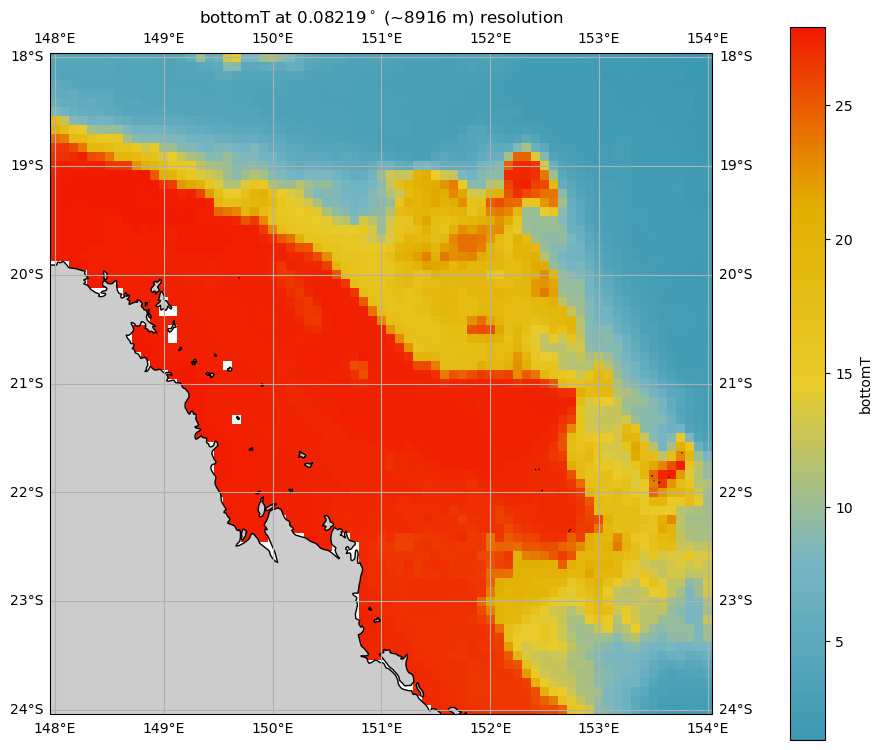

In [70]:
spatial_plots.plot_spatial(xa.open_dataset(directories.get_monthly_cmems_dir() / "Great_Barrier_Reef_C/cmems_gopr_monthly_B.nc")["bottomT"].isel(time=0))

In [ ]:
# download daily data
xa_cmems_daily, cmems_daily_path = climate_data.download_reanalysis(download_dir=directories.get_daily_cmems_dir(), 
    final_filename = "cmems_gopr_daily.nc",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1D-m")   

### Spatially pad the data

TODO: add visual explanation

In [ ]:
def spatially_buffer_timeseries(
    xa_ds: xa.Dataset,
    buffer_size: int = 3,
    exclude_vars: list[str] = ["spatial_ref", "coral_algae_1-12_degree"],
) -> xa.Dataset:
    """Applies a spatial buffer to each data variable in the xarray dataset.

    Parameters
        xa_ds (xarray.Dataset): Input xarray dataset.
        buffer_size (int): Buffer size in grid cells.
        exclude_vars (list[str]): List of variable names to exclude from buffering.

    Returns:
        xarray.Dataset: Xarray dataset with buffered data variables.
    """
    filtered_vars = [var for var in xa_ds.data_vars if var not in exclude_vars]

    buffered_ds = xa.Dataset()
    for data_var in tqdm(
        filtered_vars, desc=f"Buffering variables by {buffer_size} pixel(s)"
    ):
        buffered = xa.apply_ufunc(
            spatial_data.buffer_nans,
            xa_ds[data_var],
            input_core_dims=[[]],
            output_core_dims=[[]],
            kwargs={"size": buffer_size},
            dask="parallelized",
        )
        buffered_ds[data_var] = buffered

    return buffered_ds


def spatially_buffer_nc_file(nc_path: Path | str, buffer_size: int = 3):
    # TODO: specify distance buffer
    nc_path = Path(nc_path)
    buffered_name = nc_path.stem + f"_buffered_{buffer_size}_pixel"
    buffered_path = (nc_path.parent / buffered_name).with_suffix(".nc")

    # if buffered file doesn't already exist
    if not buffered_path.is_file():
        nc_file = xa.open_dataset(nc_path)
        buffered_ds = spatially_buffer_timeseries(
            nc_file, buffer_size=buffer_size
        )
        buffered_ds.to_netcdf(buffered_path)
    else:
        buffered_ds = xa.open_dataset(buffered_path)
        print(
            f"Area buffered by {buffer_size} pixel(s) already exists at {buffered_path}."
        )

    return buffered_ds, buffered_path

In [ ]:
# xa_cmems_monthly_buffered, _ = spatial_data.spatially_buffer_nc_file(cmems_monthly_path, buffer_size=5)
xa_cmems_daily_buffered, _ = spatially_buffer_nc_file(cmems_daily_path, buffer_size=5)
# TODO: this taking forever (seemingly getting stuck after second variable)

In [ ]:
spatial_plots.plot_DEM(xa.open_dataset(directories.get_monthly_cmems_dir() / "cmems_gopr_monthly_buffered_5_pixel")["mlotst"].isel(time=0), "")
# spatial_plots.plot_DEM(buffered["mlotst"].isel(time=0), "")

## Load ERA5 data

In [ ]:
climate_data.generate_era5_data(
    lat_lims=reef_areas.get_lat_lon_limits(area_name)[0], lon_lims=reef_areas.get_lat_lon_limits(area_name)[1])

### Congratulations!

